In [3]:
using Pkg
Pkg.activate("/Users/kgilman/Desktop/aqi-dataset-experiments/")

In [20]:
using HePPCAT, LinearAlgebra, Plots, Random, Statistics, StatsPlots
using Plots.PlotMeasures

pyplot()
Plots.scalefontsizes()
Plots.scalefontsizes(0.75)

In [6]:
using PyCall
@pyimport pickle

function mypickle(filename, obj)
    out = open(filename,"w")
    pickle.dump(obj, out)
    close(out)
 end

function myunpickle(filename)
    r = nothing
    @pywith pybuiltin("open")(filename,"rb") as f begin
        r = pickle.load(f)
    end
    return r
end

myunpickle (generic function with 1 method)

#### Load the data

In [92]:
data = myunpickle("AQI_time_by_sensor_2021-02-09-2021-02-13.pickle")[2]

data[1] .= max.(data[1],0)
data[2] .= max.(data[2],0)
# data[2] .= min.(data[2],250) ### cap maximum reading
data[1] .-= mean(data[1],dims=2)
data[2] .-= mean(data[2],dims=2);
replace!(data[2], NaN=>0)

n1 = size(data[1])[2]
n2 = size(data[2])[2]

k = 30 ### the rank of the experiment

30

In [93]:
print("Dimensions of data group 1: AirNow: " * string(size(data[1]))*"\n")
print("Dimensions of data group 2: PurpleAir: " * string(size(data[2])))

Dimensions of data group 1: AirNow: (108, 46)
Dimensions of data group 2: PurpleAir: (108, 457)

#### Scree plot of the data singular values 

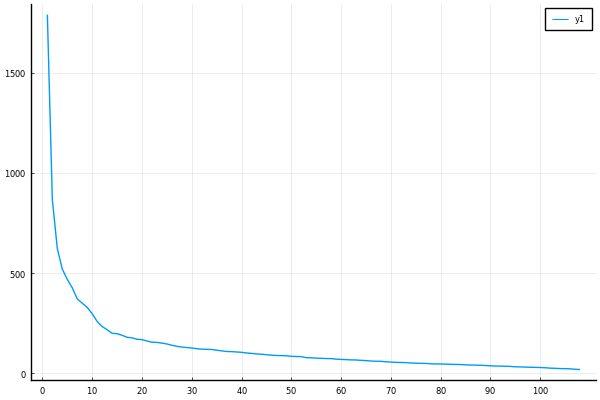

In [94]:
svals = svd(hcat(data[1],data[2])).S
plot(svals)
xticks!(0:10:108)

In [95]:
test = cumsum(svals) ./ sum(svals)
findall(x->x.>=0.7, test)[1]

35

#### Experiments

In [96]:
num_trials = 200 ###number of random training/test sets 

### Logs to record experiment stats
test_errors = zeros(4,3,num_trials)
train_errors = zeros(4,3,num_trials)
heppcat_variances = zeros(2,num_trials)

Random.seed!(0)
ntrain1 = 25 ### number of training samples for AirNow
ntrain2 = 250 ### number of training samples for PurpleAir

for iter=1:num_trials

    data[1] .= data[1][:,shuffle(1:end)]
    data[2] .= data[2][:,shuffle(1:end)]

    train1 = data[1][:,1:ntrain1]
    test1 = data[1][:,ntrain1+1:end]

    train2 = data[2][:,1:ntrain2]
    test2 = data[2][:,ntrain2+1:end]

    Ytrain = [train1,train2]
    Ytest = [test1,test2]
    Ymat_train = hcat(Ytrain...);
    Ymat_test = hcat(Ytest...);
    
    ntest1 = size(Ytest[1])[2]
    ntest2 = size(Ytest[2])[2]
    ntest = ntest1 + ntest2

    n = [size(Yl,2) for Yl in Ytrain]
    d = size(Ytrain[1],1)
    L = length(Ytrain)

    ### Homoscedastic PPCA on clean group 1 (AirNow)

    cor = Ytrain[1]*Ytrain[1]'/sum(n[1])
    λh, Uh = eigen(Hermitian(cor),sortby=-)
    λb = mean(λh[k+1:end])
    Mppca1 = HePPCATModel(Uh[:,1:k],λh[1:k] .- λb,I(k),fill(λb,L));

    ### Homoscedastic PPCA on noisy group 2 (PurpleAir)

    cor = Ytrain[2]*Ytrain[2]'/sum(n[1])
    λh, Uh = eigen(Hermitian(cor),sortby=-)
    λb = mean(λh[k+1:end])
    Mppca2 = HePPCATModel(Uh[:,1:k],λh[1:k] .- λb,I(k),fill(λb,L));

    ### Homoscedastic PPCA both groups
    L = length(Ytrain)
    cor = sum(Ytrain[l]*Ytrain[l]' for l in 1:L)/sum(n)
    λh, Uh = eigen(Hermitian(cor),sortby=-)
    λb = mean(λh[k+1:end])
    Mppca = HePPCATModel(Uh[:,1:k],λh[1:k] .- λb,I(k),fill(λb,L));
    loglikelihood_ppca = loglikelihood(Mppca,Ytrain)

    niters = 1000
    Mheppcat = heppcat(Ytrain,k,niters)
    heppcat_variances[:,iter] = Mheppcat.v

    heppcat_ll = loglikelihood(Mheppcat,Ytrain)
    ppca_ll = loglikelihood(Mppca,Ytrain)

    # print("Log-likelihood: HePPCAT: $heppcat_ll \n")
    # print("Log-likelihood: HomoPPCA: $ppca_ll")

#     errors = []
    subspaces = [Mppca1.U, Mppca2.U, Mppca.U, Mheppcat.U]
    for (i,U) in enumerate(subspaces)
        err1 = norm(Ytest[1] - U*(U'*Ytest[1])) 
        err2 = norm(Ytest[2] - U*(U'*Ytest[2])) 
        test_errors[i,1,iter] = norm(Ymat_test - U*(U'*Ymat_test)) / norm(Ymat_test)
        test_errors[i,2,iter] = err1 / norm(Ytest[1])
        test_errors[i,3,iter] = err2 / norm(Ytest[2])
        
        err1 = norm(Ytrain[1] - U*(U'*Ytrain[1])) 
        err2 = norm(Ytrain[2] - U*(U'*Ytrain[2])) 
        train_errors[i,1,iter] = norm(Ymat_train - U*(U'*Ymat_train)) / norm(Ymat_train)
        train_errors[i,2,iter] = err1 / norm(Ytrain[1])
        train_errors[i,3,iter] = err2 / norm(Ytrain[2])

    end
    
end

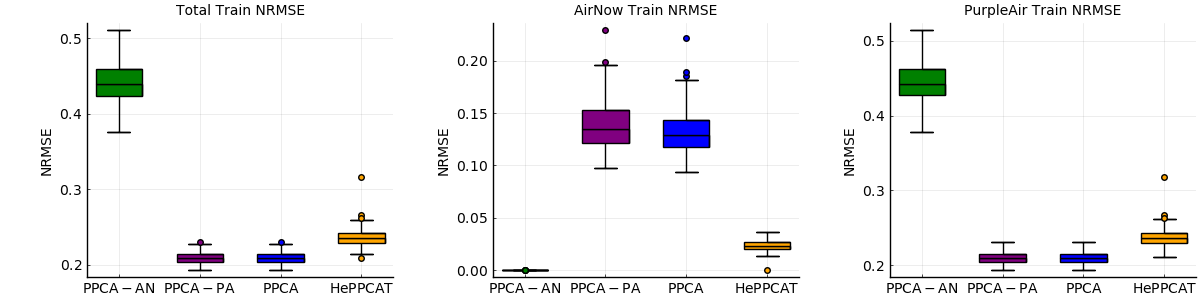

In [97]:
boxplots = []
titles = ["Total Train NRMSE","AirNow Train NRMSE","PurpleAir Train NRMSE"]


for j=1:3
    p = plot(size=(500,300))
    p = boxplot(["PPCA-AN" "PPCA-PA" "PPCA" "HePPCAT"], train_errors[:,j,:]', leg = false,title=titles[j],color=[:green :purple :blue :orange],ylabel="NRMSE")
#     p = ylims!((0,0.4))
    push!(boxplots,p)  
end

plot_boxes = plot(boxplots...,layout=(1,3),size=(1200,300),left_margin=10mm,
                    xtickfont=font(10), 
                    ytickfont=font(10), 
                    guidefont=font(10), 
                    legendfont=font(10))


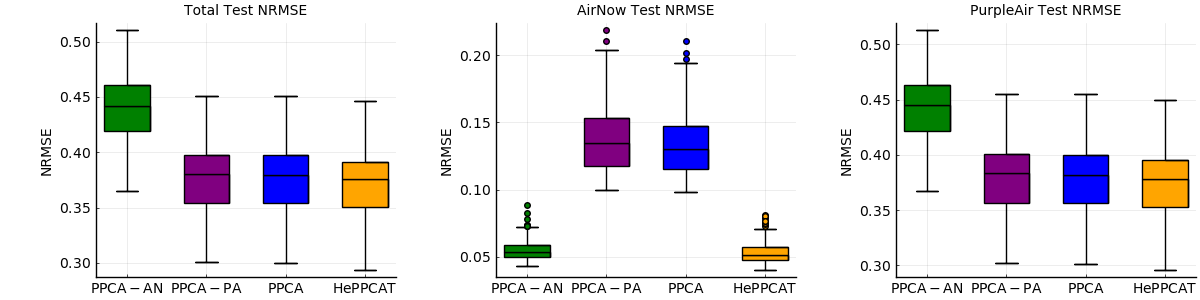

In [98]:
boxplots = []
titles = ["Total Test NRMSE","AirNow Test NRMSE","PurpleAir Test NRMSE"]
using StatsPlots

for j=1:3
    p = plot(size=(300,300))
    p = boxplot(["PPCA-AN" "PPCA-PA" "PPCA" "HePPCAT"], test_errors[:,j,:]', leg = false,title=titles[j],color=[:green :purple :blue :orange],ylabel="NRMSE")
#     p = ylims!((0,0.4))
    push!(boxplots,p)  
end

plot_boxes = plot(boxplots...,layout=(1,3),size=(1200,300),left_margin=10mm,
                    xtickfont=font(10), 
                    ytickfont=font(10), 
                    guidefont=font(10), 
                    legendfont=font(10))


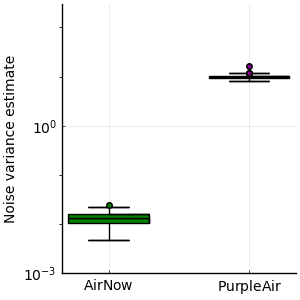

In [99]:
vboxplot = boxplot(["AirNow" "PurpleAir"], heppcat_variances',leg=false,
                    title="",
                    color=[:green :purple],ylabel="Noise variance estimate",size=(300,300),ylims=(0.001,300),yaxis=:log,
                    xtickfont=font(10), 
                    ytickfont=font(10), 
                    guidefont=font(10), 
                    legendfont=font(10))